In [17]:
import os, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imagehash
import sklearn.metrics as metrics
import skimage

### Define data paths

In [2]:
path_data = os.path.dirname(os.getcwd())+'/data/'
print(path_data)

/home/endrit_p/Documents/Spring23_CGG/data/


In [3]:
path_train_10x = path_data + "processed/train/10x/"
path_train_8x = path_data + "raw/CGG_data/train/8x/"
path_train_gt = path_data + "raw/CGG_data/train/gt/"
path_test_ge = path_data + "raw/CGG_data/ge_test/"
path_test_senti = path_data + "raw/CGG_data/senti_test/"

**check if directories contain same filenames**

In [4]:
print(os.listdir(path_train_10x) == os.listdir(path_train_8x))
print(os.listdir(path_train_10x) == os.listdir(path_train_gt))

True
True


### Find cases where the 10x res is not roughly 10x downsampled from the GT (FROM JSON)

In [10]:
path_json = path_data + "train/training.json"
print(path_json)

/home/endrit_p/data/CGG_data/train/training.json


In [63]:
with open(path_json, 'r') as f:
  training_json = json.load(f)

In [64]:
training_json['images'][0]

{'gt': {'id': 3456, 'file_name': '3456.png', 'width': 1055, 'height': 1046},
 '8x': {'id': 3456, 'file_name': '3456.png', 'width': 131, 'height': 130},
 '10x': {'id': 3456, 'file_name': '3456.png', 'width': 10550, 'height': 10460}}

In [65]:
incorrect_res = []

for i in range(len(os.listdir(path_train_10x))):
    gt_width = training_json['images'][i]['gt']['width']
    gt_height = training_json['images'][i]['gt']['height']
    down10_width = training_json['images'][i]['10x']['width']
    down10_height = training_json['images'][i]['10x']['height']
    width_ratio = gt_width / down10_width
    height_ratio = gt_height / down10_height
    if(training_json['images'][i]['10x']['id'] != training_json['images'][i]['gt']['id']):
        print("ids dont match: " + str(training_json['images'][i]['10x']['id']))
    if(width_ratio < 10 or height_ratio < 10):
        print("id = " + str(training_json['images'][i]['gt']['id']))
        #print("width ratio (gt/10x) = " + str(width_ratio))
        #print("height ratio (gt/10x) = " + str(height_ratio))
        incorrect_res.append(training_json['images'][i]['10x']['id'])

id = 3456
id = 2423
id = 3245
id = 3330
id = 2957
id = 1319
id = 1320
id = 1321
id = 1322
id = 1323
id = 1325
id = 1326
id = 1327


### Compare perceptual image hashes for 10x vs GT

In [80]:
def compare_image_phash(img1, img2):
    hash1 = imagehash.phash(img1)
    hash2 = imagehash.phash(img2)
    return hash1-hash2

In [81]:
gt_vs_10x_hashes = []

In [82]:
for fn in os.listdir(path_train_10x):
    img_gt = Image.open(path_train_gt + fn)
    img_10x = Image.open(path_train_10x + fn)
    gt_vs_10x_hashes.append(compare_image_phash(img_gt, img_10x))

In [84]:
max(gt_vs_10x_hashes)

2

In [87]:
os.listdir(path_train_10x)[np.argmax(gt_vs_10x_hashes)]

'1332.png'

### Image dimensions

In [5]:
def get_all_image_dim(path):
    img_dimensions = []
    for fn in os.listdir(path):
        img = Image.open(path + fn)
        width, height = img.size
        img_dimensions.append([width, height])
    return img_dimensions

In [100]:
train_gt_dim = np.array(get_all_image_dim(path_train_gt))

In [ ]:
train_8x_dim = np.array(get_all_image_dim(path_train_8x))

In [105]:
train_10x_dim = np.array(get_all_image_dim(path_train_10x))

In [163]:
test_ge_dim = np.array(get_all_image_dim(path_test_ge))

In [164]:
test_senti_dim = np.array(get_all_image_dim(path_test_senti))

**GT**

In [194]:
# widths
np.unique(train_gt_dim[:, 0], return_counts=True)

(array([ 693,  694,  695,  696,  697,  698, 1034, 1035, 1036, 1037, 1038,
        1039, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050,
        1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059]),
 array([  1,   2,   2,  26,  43,   4,   6,  35,  54,  84,  59,   3,   8,
         14,   6,  23,  36,  27,  30,   9,  27,  43,  58,  70,  69, 130,
        185,  79,  51,  39,   5]))

In [195]:
# heights
np.unique(train_gt_dim[:, 1], return_counts=True)

(array([ 697,  698,  699,  700,  701, 1042, 1043, 1044, 1045, 1046, 1047,
        1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058,
        1059, 1060, 1061, 1063, 1064, 1065, 1066, 1067, 1068]),
 array([ 28,  44,   3,   2,   1,   1,  15,  56,  51, 118, 172, 118,  55,
         65,  52,  40,  14,  20,  23,  30,  41,  10,   9,  17,   2,  10,
         79,  77,  47,  27,   1]))

In [168]:
print("max width in GT: " + str(max(train_gt_dim[:, 0])))
print("max height in GT: " + str(max(train_gt_dim[:, 1])))
print("min width in GT: " + str(min(train_gt_dim[:, 0])))
print("min height in GT: " + str(min(train_gt_dim[:, 1])))

max width in GT: 1059
max height in GT: 1068
min width in GT: 693
min height in GT: 697


In [169]:
print("max width in 8x: " + str(max(train_8x_dim[:, 0])))
print("max height in 8x: " + str(max(train_8x_dim[:, 1])))
print("min width in 8x: " + str(min(train_8x_dim[:, 0])))
print("min height in 8x: " + str(min(train_8x_dim[:, 1])))

max width in 8x: 132
max height in 8x: 133
min width in 8x: 86
min height in 8x: 87


In [170]:
print("max width in 10x: " + str(max(train_10x_dim[:, 0])))
print("max height in 10x: " + str(max(train_10x_dim[:, 1])))
print("min width in 10x: " + str(min(train_10x_dim[:, 0])))
print("min height in 10x: " + str(min(train_10x_dim[:, 1])))

max width in 10x: 105
max height in 10x: 106
min width in 10x: 69
min height in 10x: 69


In [171]:
print("max width in test ge: " + str(max(test_ge_dim[:, 0])))
print("max height in test ge: " + str(max(test_ge_dim[:, 1])))
print("min width in test ge: " + str(min(test_ge_dim[:, 0])))
print("min height in test ge: " + str(min(test_ge_dim[:, 1])))

max width in test ge: 125
max height in test ge: 125
min width in test ge: 125
min height in test ge: 125


In [172]:
print("max width in test senti: " + str(max(test_senti_dim[:, 0])))
print("max height in test senti: " + str(max(test_senti_dim[:, 1])))
print("min width in test senti: " + str(min(test_senti_dim[:, 0])))
print("min height in test senti: " + str(min(test_senti_dim[:, 1])))

max width in test senti: 128
max height in test senti: 128
min width in test senti: 128
min height in test senti: 128


### Aspect ratios

In [156]:
train_gt_ar = train_gt_dim[:, 0] / train_gt_dim[:, 1]
train_8x_ar = train_8x_dim[:, 0] / train_8x_dim[:, 1]
train_10x_ar = train_10x_dim[:, 0] / train_10x_dim[:, 1]

In [175]:
print("mean GT AR: " + str(np.mean(train_gt_ar)))
print("max GT AR: " + str(max(train_gt_ar)))
print("min GT AR: " + str(min(train_gt_ar)))

mean GT AR: 0.9970515843642815
max GT AR: 1.0163147792706333
min GT AR: 0.9681647940074907


In [176]:
print("mean 8x AR: " + str(np.mean(train_8x_ar)))
print("max 8x AR: " + str(max(train_8x_ar)))
print("min 8x AR: " + str(min(train_8x_ar)))

mean 8x AR: 0.9962252292171475
max 8x AR: 1.0153846153846153
min 8x AR: 0.9699248120300752


In [177]:
print("mean 10x AR: " + str(np.mean(train_10x_ar)))
print("max 10x AR: " + str(max(train_10x_ar)))
print("min 10x AR: " + str(min(train_10x_ar)))

mean 10x AR: 0.9974586153301352
max 10x AR: 1.0096153846153846
min 10x AR: 0.9716981132075472


### Downsampling scale factors

In [188]:
scaling_10x_w = train_gt_dim[:, 0] / train_10x_dim[:, 0]
scaling_10x_h = train_gt_dim[:, 1] / train_10x_dim[:, 1]

In [189]:
print("max ratio of width gt/10x: " + str(max(scaling_10x_w)))
print("min ratio of width gt/10x: " + str(min(scaling_10x_w)))
print("max ratio of height gt/10x: " + str(max(scaling_10x_h)))
print("min ratio of height gt/10x: " + str(min(scaling_10x_h)))

max ratio of width gt/10x: 10.115942028985508
min ratio of width gt/10x: 10.0
max ratio of height gt/10x: 10.130434782608695
min ratio of height gt/10x: 10.0


### Image pixel densities

In [106]:
train_gt_pixels = train_gt_dim[:, 0] * train_gt_dim[:, 1]
train_8x_pixels = train_8x_dim[:, 0] * train_8x_dim[:, 1]
train_10x_pixels = train_10x_dim[:, 0] * train_10x_dim[:, 1]

In [123]:
np.unique(train_gt_pixels, return_counts=True)

(array([ 485106,  485112,  485793,  485800,  485805,  485808,  485809,
         486500,  486504,  486506, 1102331, 1102464, 1102475, 1102484,
        1102499, 1103278, 1103310, 1103340, 1103368, 1103394, 1103460,
        1103478, 1103494, 1103508, 1103520, 1103530, 1103538, 1103544,
        1103548, 1103550, 1104312, 1104345, 1104376, 1104405, 1104432,
        1104457, 1104501, 1104520, 1104537, 1104552, 1104565, 1104576,
        1104585, 1104592, 1104597, 1104600, 1104601, 1105412, 1105442,
        1105470, 1105496, 1105562, 1105596, 1105610, 1105622, 1105632,
        1105640, 1105646, 1105650, 1105652]),
 array([  1,   3,   1,   1,   1,  22,  21,   1,   1,  26,   1,   1,   2,
          1,   2,   5,  18,  21,  32,   8,   7,   4,  12,  42,  38,  78,
         68,  47,  41,  41,   1,  17,  28,  50,  45,   1,   1,  10,   9,
         35,  45,  61, 125,  77,  35,  66,  32,   5,   1,   6,   2,   1,
          1,   2,   5,   9,   3,   4,   1,   3]))

In [122]:
np.unique(train_8x_pixels, return_counts=True)

(array([ 7482,  7569, 17028, 17030, 17157, 17160, 17161]),
 array([  5,  73,  10, 274, 231, 283, 352]))

In [121]:
np.unique(train_10x_pixels, return_counts=True)

(array([ 4761,  4830, 10918, 10920, 11024, 11025]),
 array([ 75,   3, 241, 747,  19, 143]))

In [152]:
best_gt_im = os.listdir(path_train_gt)[np.argmax(train_gt_pixels)]
worst_gt_im = os.listdir(path_train_gt)[np.argmin(train_gt_pixels)]
print(np.max(train_gt_pixels))
print(np.min(train_gt_pixels))

1105652
485106


In [154]:
print(train_gt_dim[np.argmax(train_gt_pixels)])
print(train_gt_dim[np.argmin(train_gt_pixels)])

[1052 1051]
[694 699]


[Text(0.5, 1.0, 'Worst GT image: 1895.png')]

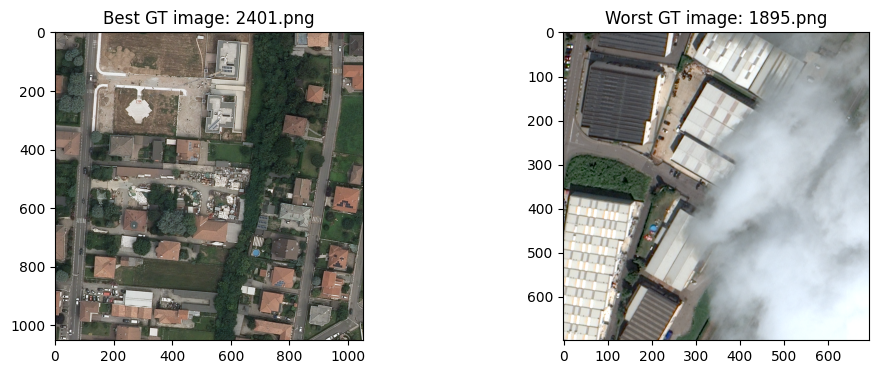

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].imshow(Image.open(path_train_gt + best_gt_im))
ax[0].set(title = "Best GT image: " + best_gt_im)
ax[1].imshow(Image.open(path_train_gt + worst_gt_im))
ax[1].set(title = "Worst GT image: " + worst_gt_im)

In [208]:
imtest = cv2.imread(path_train_gt + best_gt_im)

**24 bit image**

In [211]:
imtest.dtype

dtype('uint8')

### Testing uniformity of data by recursively smoothing image (bigger MSE drops = sharper image)

In [9]:
im_best  = cv2.imread(path_train_gt +"2401.png")
im_worst = cv2.imread(path_train_gt + "1895.png")

In [10]:
mse_im_best = []
for i in range(10):
    im_new = cv2.GaussianBlur(im_best, (5, 5), 2)
    mse = metrics.mean_squared_error(im_best.transpose(2,0,1).reshape(3,-1), im_new.transpose(2,0,1).reshape(3,-1))
    mse_im_best.append(mse)
    im_best = im_new

In [11]:
mse_im_worst = []
for i in range(10):
    im_new = cv2.GaussianBlur(im_worst, (5, 5), 2)
    mse = metrics.mean_squared_error(im_worst.transpose(2,0,1).reshape(3,-1), im_new.transpose(2,0,1).reshape(3,-1))
    mse_im_worst.append(mse)
    im_worst = im_new

In [12]:
np.diff(mse_im_best)

array([-34.6828345 ,  -7.4102207 ,  -2.26268482,  -0.94212133,
        -0.47450192,  -0.27375491,  -0.17320338,  -0.1180094 ,
        -0.08368335])

In [13]:
np.diff(mse_im_worst)

array([-12.28020749,  -3.51332836,  -1.43309435,  -0.68659015,
        -0.37871311,  -0.23098319,  -0.15383786,  -0.10479771,
        -0.07761328])

[Text(0.5, 1.0, 'smoothed worst GT image')]

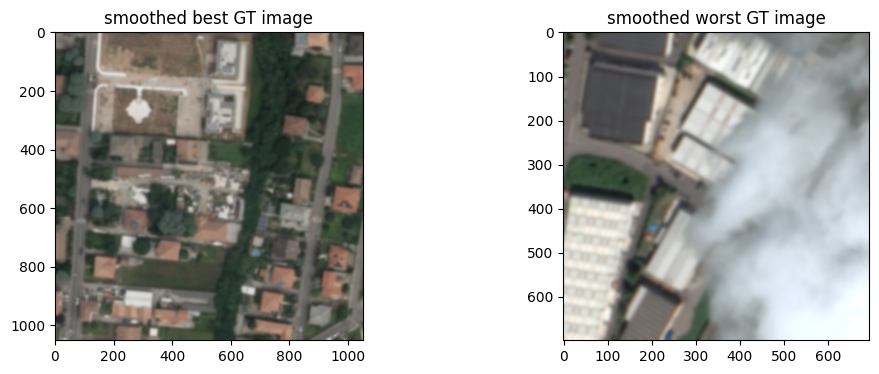

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].imshow(im_best[..., : : -1])
ax[0].set(title = "smoothed best GT image")
ax[1].imshow(im_worst[..., : : -1])
ax[1].set(title = "smoothed worst GT image")

### Fourier transforms

In [18]:
im_best  = cv2.imread(path_train_gt +"2401.png")
im_worst = cv2.imread(path_train_gt + "1895.png")

im_best_grey = cv2.cvtColor(im_best, cv2.COLOR_BGR2GRAY)
im_worst_grey = cv2.cvtColor(im_worst, cv2.COLOR_BGR2GRAY)

In [24]:
im_best_fft = np.fft.fftshift(np.fft.fft2(im_best_grey))
im_worst_fft = np.fft.fftshift(np.fft.fft2(im_worst_grey))

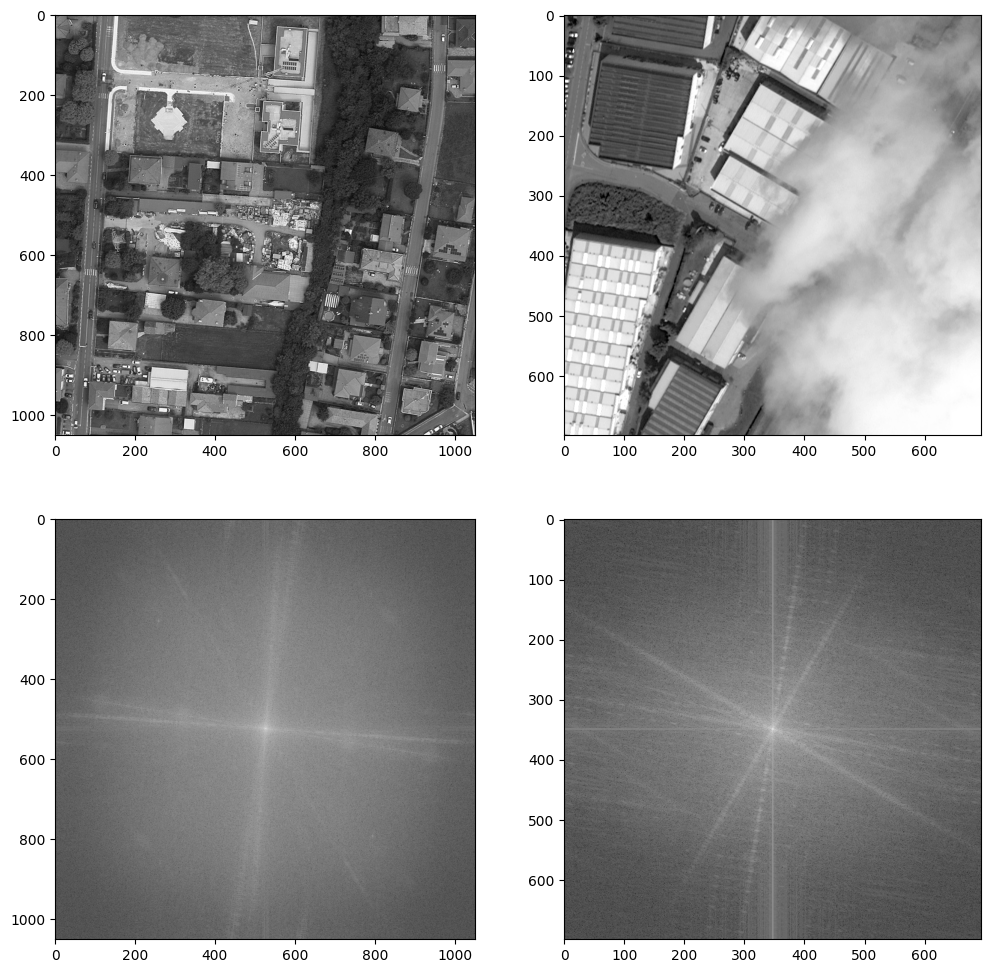

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

ax[0][0].imshow(im_best_grey, cmap='gray')
ax[0][1].imshow(im_worst_grey, cmap='gray')
ax[1][0].imshow(np.log(abs(im_best_fft)), cmap='gray')
ax[1][1].imshow(np.log(abs(im_worst_fft)), cmap='gray')

### Population statistics

In [227]:
def resize_image(input_img, desired_size, **kwargs):
    '''
    for a given image (or path to image), rescale to desired size
    opencv based image resizing
    '''
    if isinstance(input_img, str):
        img = cv2.imread(input_img)
    else:
        img = input_img
    
    img_resized = cv2.resize(img, desired_size, **kwargs)
    return img_resized

In [229]:
all_imgs = []
for fn in os.listdir(path_train_10x):
    img = cv2.imread(path_train_10x + fn)
    img = resize_image(img, (128, 128))
    all_imgs.append(img)

In [231]:
all_imgs = np.array(all_imgs)

In [232]:
all_imgs.shape

(1228, 128, 128, 3)

In [233]:
np.mean(all_imgs)

103.59837949340688

In [234]:
np.std(all_imgs)

47.042696179250775

In [236]:
print(np.mean(np.reshape(all_imgs[:, :, :, 0], -1)))
print(np.mean(np.reshape(all_imgs[:, :, :, 1], -1)))
print(np.mean(np.reshape(all_imgs[:, :, :, 2], -1)))

96.12582954133373
108.62561228997544
106.04369664891146


In [237]:
print(np.std(np.reshape(all_imgs[:, :, :, 0], -1)))
print(np.std(np.reshape(all_imgs[:, :, :, 1], -1)))
print(np.std(np.reshape(all_imgs[:, :, :, 2], -1)))

44.371497241638686
43.88094320214925
51.551791426649174
